# Stack Exchange Network
## Understanding users and products using the Stack Exchange network
<img src="stackexchange_image.png">


## Introduction

The Stack Exchange (SE) network is a collection of Q&A websites where enthusiast and experts come together to share their knowledge. Currently the SE network is one of the top 50 online sites with approximately 838 million views per month [1]. The network encompasses a wide variety of subjects ranging from home improvement to computer programming. 

[1]: Statistics reported at https://stackexchange.com/about

## Objectives

The objectives of this work are to understand SE users and related products to create a more cohesive and stronger SE network. To this end we consider three questions:

1) What are some of the characteristics of users who provide accepted answers? <br>
2) Which users have untapped potential that could be used to improve the Stack Exchange network? How much improvement could these users provide?<br>
3) Based on SE posts, what topics are important in the present and in the future? Are there opportunities for new SE sites?

Currently this analysis is focused on the SE site superuser.com which focuses on computer related topics. Future work will be applied to the entire SE network.

## Key results

1) A significant number of answer providers on superuser.com are contributors to unexpected SE sites like English.stackexchange.com <br>
2) Using machine learning, I identify 25,374 SE accounts that are not members of superuser.com but could potentialy provide up to 58,479 answers. This represents a 23.45% increase in answered questions. <br>
3) We analyze different hardware and software tag combinations and discover that Mac OS has significantly fewer questions related to graphics cards when compared to Linux, Ubuntu, and Windows.


## Broader impact

Forums and Q&A websites like Stack Exchange are one of the best places to ask questions and resolve problems quickly. In this work, we are able to better understand the SE network as a whole when hidden connections are revealed. This promotes thinking of superuser.com as a part of the larger SE ecosystem. As SE sites can be created or closed, this information is relevant when considering whether to start or stop supporting an SE site. The same principles are relevant to other sites and can be extended a family of connected products, e.g. google, apple, windows, etc.



## Stack Exchange Data

The Stack Exchange network provides access to their website data at the [Stack Exchange Data Dump](https://archive.org/details/stackexchange). Currently there is over 60GBs of data available on users, posts, comments etc. Here we consider the user and post data from superuser.com and supplement the analysis with user data from the largest SE sites. 

- There are 1,038,245 superuser.com posts with 20 features such as title, tags, view count, and score.
- There are 803,552 users on superuser.com with 12 features such as reputation, upvotes, downvotes, etc.

In the final project, we will incorporate data from all SE sites.

# Data analysis:
Start data analysis by loading libraries, importing data, and cleaning data.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load superuser.com post and user data
posts_superuser = pd.read_csv('./superuser.com/Posts.csv')
users_superuser = pd.read_csv('./superuser.com/Users.csv')

In [3]:
# Fix data types
posts_superuser[['LastEditDate','LastActivityDate','CommunityOwnedDate','ClosedDate','CreationDate']] = \
    posts_superuser[['LastEditDate','LastActivityDate','CommunityOwnedDate','ClosedDate','CreationDate']].apply(pd.to_datetime)
posts_superuser[['AnswerCount','FavoriteCount','ParentID','AcceptedAnswerId','ViewCount','OwnerUserId','LastEditorUserId']] = \
    posts_superuser[['AnswerCount','FavoriteCount','ParentID','AcceptedAnswerId','ViewCount','OwnerUserId','LastEditorUserId']].astype('Int64')

users_superuser['AccountId'] = users_superuser['AccountId'].astype('Int64')
users_superuser.drop(columns = ['CreationDate','LastAccessDate','WebsiteUrl','Location','AboutMe'],inplace = True)
print('Finished cleaning data')

Finished cleaning data


## Question 1:

What are some of the characteristics of users who provide accepted answers on superuser.com?

There are a variety of possible features that describe users who post answers. Here we look at whether these users are members of other SE sites to identify what subjects they are interested in.

In [4]:
# Filter for accepted answers only
accepted_answer_ids = posts_superuser.AcceptedAnswerId[~posts_superuser.AcceptedAnswerId.isnull()]
accepted_answer_posts = posts_superuser[posts_superuser.Id.isin(accepted_answer_ids)]

# get number of accepted answer for each unique user ID 
tmp = pd.DataFrame(accepted_answer_posts.OwnerUserId.value_counts().reset_index())
tmp.columns = ['userId','AcceptedAnswerCount']

# Add column to users df to include accepted answer count 
superusers_with_accepted_answers = pd.merge(users_superuser, tmp, left_on='Id', right_on='userId')
superusers_with_accepted_answers.drop(columns = ['userId'],inplace = True)




In [5]:
# improve prediction of answer by finding new feature which reflect
# are they members of other SE sites

users_android = pd.read_csv('android.stackexchange.com/Users.csv')
users_apple = pd.read_csv('apple.stackexchange.com/Users.csv')
users_askubuntu = pd.read_csv('askubuntu.com/Users.csv')
users_bicycles = pd.read_csv('bicycles.stackexchange.com/Users.csv')
users_codereview = pd.read_csv('codereview.stackexchange.com/Users.csv')
users_dba = pd.read_csv('dba.stackexchange.com/Users.csv')
users_electronics = pd.read_csv('electronics.stackexchange.com/Users.csv')
users_english = pd.read_csv('english.stackexchange.com/Users.csv')
users_gaming = pd.read_csv('gaming.stackexchange.com/Users.csv')
users_math = pd.read_csv('math.stackexchange.com/Users.csv')
users_movies = pd.read_csv('movies.stackexchange.com/Users.csv')
users_music = pd.read_csv('music.stackexchange.com/Users.csv')
users_outdoors = pd.read_csv('outdoors.stackexchange.com/Users.csv')
users_physics = pd.read_csv('physics.stackexchange.com/Users.csv')
users_security = pd.read_csv('security.stackexchange.com/Users.csv')
users_serverfault = pd.read_csv('serverfault.com/Users.csv')
users_softwareengineering = pd.read_csv('softwareengineering.stackexchange.com/Users.csv')
users_stats = pd.read_csv('stats.stackexchange.com/Users.csv')
users_unix = pd.read_csv('unix.stackexchange.com/Users.csv')
users_webapps = pd.read_csv('webapps.stackexchange.com/Users.csv')


In [6]:
i = 0
SE_site = ['android','apple','askubuntu','bicycles','codereview','dba','electronics','english','gaming','math',
          'movies','music','outdoors','physics','security','serverfault','softwareengineering','stats','unix','webapps']

for user_site in (users_android,users_apple,users_askubuntu,users_bicycles,users_codereview,users_dba,
                 users_electronics,users_english,users_gaming,users_math,users_movies,users_music,
                 users_outdoors,users_physics,users_security,users_serverfault,users_softwareengineering,
                 users_stats,users_unix,users_webapps):
    site_string = SE_site[i] + '_userId'
    rep_string = SE_site[i] + '_reputation'
    user_site['AccountId'] = user_site['AccountId'].astype('Int64')
    user_site.rename(columns = {'Id': site_string, 'Reputation': rep_string},inplace = True)
    user_site.drop(columns = ['CreationDate','DisplayName','LastAccessDate','WebsiteUrl','Location','AboutMe','Views','UpVotes','DownVotes'],inplace = True)
    user_site[[site_string, rep_string]] = user_site[[site_string, rep_string]].astype('Int64')
    # add user id and reputation from other sites to superusers_with_accepted_answers
    superusers_with_accepted_answers = pd.merge(superusers_with_accepted_answers, user_site, how = 'left', left_on='AccountId', right_on='AccountId')
    i += 1
    


In [7]:
# Count the number of super users on each site
users_superuser100 = superusers_with_accepted_answers[superusers_with_accepted_answers.AcceptedAnswerCount >= 100]
site_superuser_counts = users_superuser100.iloc[:,[8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46]].count()

# write user ids to dataframe for further post analysis
users_superuser100.to_csv(r'superusers_with_100answers.csv',index = None, header = True)

member_counts = pd.DataFrame({'SE_site': SE_site, 'member_count': site_superuser_counts})
member_counts = member_counts.sort_values(by = 'member_count', ascending = False)

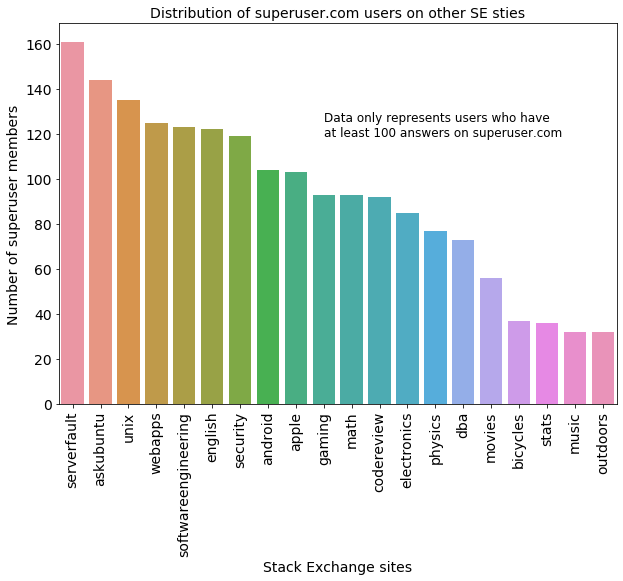

In [8]:
fig = plt.figure(figsize=(10,7))
# ax = sns.barplot(x=SE_site, y=site_superuser_counts)
ax = sns.barplot(x=member_counts.SE_site, y=member_counts.member_count)
plt.xlabel('Stack Exchange sites',fontsize = 14)
plt.ylabel('Number of superuser members',fontsize = 14)
plt.title('Distribution of superuser.com users on other SE sties',fontsize = 14)
plt.text(9, 120, 'Data only represents users who have\n at least 100 answers on superuser.com', ha='left', fontsize = 12, wrap=True)
ax.tick_params(axis = 'both', labelsize = 14)
plt.xticks(rotation=90)
plt.show()

fig.savefig('DI_figure1.png',bbox_inches = "tight")

## Figure 1
Here we plot the number of superuser members on other SE sites. We find that:

- As one expects, users who are have at least 100 accepted answers on superuser.com are also interested in other STEM subjects like Ubuntu, Android, Apple, math, and physics
- Surprisingly, English SE is one of the most popular networks and it is not a STEM subject

This surprising result merits further investigation but suggests a correlation between an interest in english and ones ability to answer computer related questions. 

Note: This data only represents users who have at least 100 answers on superuser.com


## Question 2:

Based on the results of question 1, we find that the performance of answer providers is correlated to their activity and interest in other SE topics. Therefore we now ask: 

- Which users have untapped potential that could be used to improve the Stack Exchange network? 
- How much improvement could these users provide?

We quantify the performance of members on superuser.com by the number of accepted answers. Member activity on other sites is quantified by their reputation on other sites

To answer this question we perform the following:

- Train a machine learning model to predict the number of accepted answer posts using current users on superuser.com
- Validate machine learning model using withheld superuser.com data
- Identify accounts who do not have superuser accounts yet as possible contributors
- Use machine learning model to predict the number of potential answers that could be provided


In [9]:
# create dataframe with user data and reputation on the SE network
regr_data = superusers_with_accepted_answers.copy()
regr_data.fillna(0,inplace = True)
# regr_data = regr_data[regr_data.AcceptedAnswerCount < 1000]

# Define features and target to be used in regression models
features = ['android_reputation','apple_reputation','askubuntu_reputation','bicycles_reputation',
            'codereview_reputation','dba_reputation','electronics_reputation','english_reputation',
            'gaming_reputation','math_reputation','movies_reputation','music_reputation','outdoors_reputation',
            'physics_reputation','security_reputation','serverfault_reputation','softwareengineering_reputation',
            'stats_reputation','unix_reputation','webapps_reputation']
target = ['AcceptedAnswerCount']

X = regr_data[features]
# Normalize target data to improve machine learning results
y = np.log1p(regr_data[target])

# Split available data into training and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Comparison of three different machine learning models: 
- Multivariate Linear Regression
- Decision Tree
- Random Forest

Decision Tree and Random forest are tuned to minimize error.

In [10]:
## Linear model
rep_linear_model = LinearRegression()
rep_linear_model.fit(X_train,y_train)
y_pred = rep_linear_model.predict(X_test)

## Decision Tree
DT_model = DecisionTreeRegressor(random_state = 0,max_depth = 6,max_leaf_nodes = 20)
DT_model.fit(X_train,y_train)
DTy_pred = DT_model.predict(X_test)

## Random Forest
RF_model = RandomForestRegressor(random_state = 2,max_depth = 9,max_leaf_nodes = 67)
RF_model.fit(X_train,y_train)
RFy_pred = RF_model.predict(X_test)

print('Multivariate linear regression mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(np.expm1(y_test),np.expm1(y_pred)))
print('Decision tree mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(np.expm1(y_test),np.expm1(DTy_pred)))
print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(np.expm1(y_test),np.expm1(RFy_pred)))

Multivariate linear regression mean absolute error (MAE): 3.563
Decision tree mean absolute error (MAE): 3.089
Random forest mean absolute error (MAE): 3.088


In [11]:
# find users who could provide answers but have not yet. 
potential_accounts = []

# Search users among other sites who are not users on superuser.com yet
for user_site in (users_android,users_apple,users_askubuntu,users_bicycles,users_codereview,users_dba,
                 users_electronics,users_english,users_gaming,users_math,users_movies,users_music,
                 users_outdoors,users_physics,users_security,users_serverfault,users_softwareengineering,
                 users_stats,users_unix,users_webapps):
    # filter for accounts that accounts that are not on superuser.com and have at least 100 rep on each site
    potential_accounts += list(user_site.AccountId[~user_site.AccountId.isin(superusers_with_accepted_answers.AccountId) & (user_site.iloc[:,1] > 100)])

potential_accounts = list(set(potential_accounts))

new_superusers = pd.DataFrame({'AccountId': potential_accounts})
new_superusers['AccountId'] = new_superusers['AccountId'].astype('Int64')

# collect features for each of the potential new superuser contributors
for user_site in (users_android,users_apple,users_askubuntu,users_bicycles,users_codereview,users_dba,
                 users_electronics,users_english,users_gaming,users_math,users_movies,users_music,
                 users_outdoors,users_physics,users_security,users_serverfault,users_softwareengineering,
                 users_stats,users_unix,users_webapps):
    # add user id and reputation from other sites to users_superuser
    new_superusers = pd.merge(new_superusers, user_site, how = 'left', left_on='AccountId', right_on='AccountId')

# clean the new input data
new_superusers.fillna(0,inplace = True)


In [12]:
# Predict the number of potential new answers using random forest model
newX = new_superusers[features]
RFy_pred = RF_model.predict(newX)
# Convert prediction units back to accepted answer count
RFy_pred = np.expm1(RFy_pred)

# store predictions in new dataframe
new_answers = pd.DataFrame({'AccountId': new_superusers.AccountId, 'NewAnswerCount': RFy_pred})
new_answers['NewAnswerCount'] = new_answers.NewAnswerCount.apply(np.floor)
# Ignore users with 1 or less answers as these users are not necessarily reliable
new_answers = new_answers[new_answers.NewAnswerCount > 1]

# Count number of unanswered questions on superuser.com
superuser_unanswered_count = len(posts_superuser[(posts_superuser.PostTypeId == 1) & (posts_superuser.AcceptedAnswerId.isna())])
total_new_answer_count = int(new_answers['NewAnswerCount'].sum())
# Calculate impact on superuser.com
pcent_new_answers = ((new_answers['NewAnswerCount'].sum()/superuser_unanswered_count)*100)

# Filter superuser.com posts for questions only
posts_questions =  posts_superuser[posts_superuser.PostTypeId == 1]

print('There are', len(new_answers), 'potential new users that are predicted to answer',
      total_new_answer_count, 'questions.')
print('This is roughly %5.2f' % (pcent_new_answers), 'percent of the unanswered questions.')

There are 25374 potential new users that are predicted to answer 58479 questions.
This is roughly 23.46 percent of the unanswered questions.


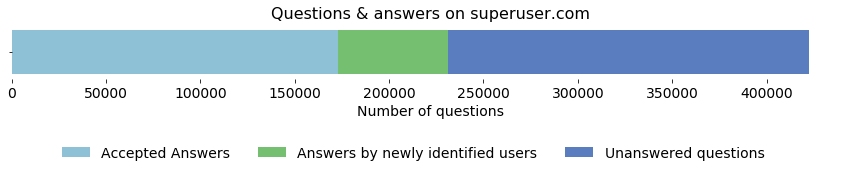

In [13]:
f = plt.figure(figsize=(15, 1))
sns.set_color_codes("muted")
sns.barplot(x = len(posts_questions), y = [''], color = 'b', label = 'Unanswered questions')
sns.barplot(x = len(accepted_answer_posts) + total_new_answer_count, y = [''],color = 'g',
            label = 'Answers by newly identified users')
sns.barplot(x = len(accepted_answer_posts), y = [''],color = 'c', label = 'Accepted Answers')

ax = plt.gca()
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.48, -1.0), frameon=True, fontsize = 14)
plt.xlabel('Number of questions',fontsize = 14)
plt.title('Questions & answers on superuser.com', fontsize = 16)
ax.tick_params(axis = 'both', labelsize = 14)
sns.despine(left=True, bottom=True, right=True)

handles, labels = ax.get_legend_handles_labels()
order = [2,1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol = 3,
          loc='upper center', bbox_to_anchor=(0.48, -1.0), frameon=False, fontsize = 14)


## Figure 2
<h1><center> <b> <font size="5">Potential new users: 25,374 &emsp;&emsp;&emsp; Potential new answers: 58,479 </font></b> </center></h1>
<h1><center> <b> <font size="5">This would push the number of accepted answers to 54% of all questions. </font></b> </center></h1>

Using machine learning, I identified 25,374 Stack exchange network users who could potentially contribute meaningful answers to superuser.com. Random forest models predict up to 58,479 new answers. This could improve the quality of superuser.com by pushing the number of answers to 54% of all questions.


## Question 3:

Based on superuser.com posts, what topics are important in the present and in the future?

To identify the most important topics, we analyze the some of the most popular tags which appear on superuser.com. We compare all the possible combinations of various hardware and software tags to better understand how different system combinations perform.



In [14]:
# Select top software and hardware tags from superuser.com
software_tags = ['linux','ubuntu','windows','macos','google-chrome',
                 'virtualbox','firefox','ffmpeg','python','microsoft-office']
hardware_tags = ['hard-drive','router','usb','laptop','memory','cpu','ssd','keyboard','graphics-card','display']

In [15]:
# Count the number of times each hardware tag appears with each software tag
tag_combo_counts = pd.DataFrame(columns=['SoftwareTag','HardwareTag','Count'])

for i in range(len(software_tags)):
    software_string = '<' + software_tags[i] + '>'
    tmp = []
    # get question posts that contain software string
    tmp = posts_questions[posts_questions.Tags.str.contains(software_string,na = False)]
    tag_count = [-1]*len(software_tags)
    for j in range(len(hardware_tags)):
        hardware_string = '<' + hardware_tags[j] + '>'
        tag_count[j] = (tmp.Tags.str.count(hardware_string)).sum() 
        
    tmp_df = pd.DataFrame({'SoftwareTag': [software_tags[i]]*len(hardware_tags),
                          'HardwareTag': hardware_tags,
                          'Count': tag_count})
    tag_combo_counts = pd.concat([tag_combo_counts,tmp_df])
    
tag_combo_counts.Count = pd.to_numeric(tag_combo_counts.Count)
tag_combo_counts.fillna(0,inplace = True)

# Scale the tag counts using ln(count+1) because counts differ by several orders of magnitude
tag_combo_counts.Count = np.log1p(tag_combo_counts.Count)
tag_combo_pivot = tag_combo_counts.pivot(index = 'HardwareTag',columns = 'SoftwareTag',values='Count')

# Set order of columns to make figure more understandable
column_order = ['linux','ubuntu','windows','macos','virtualbox',
                'google-chrome','firefox','ffmpeg','python','microsoft-office']

tag_combo_pivot = tag_combo_pivot.reindex(column_order,axis = 1)

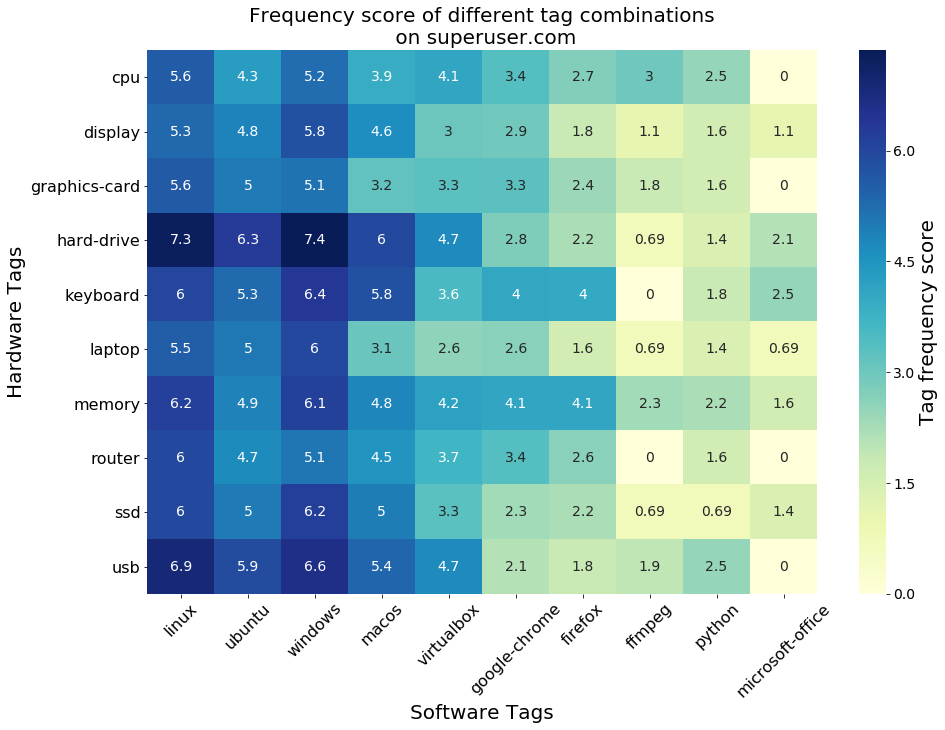

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(tag_combo_pivot,annot=True,cmap="YlGnBu",ax = ax,
            annot_kws={"size": 14},cbar_kws={'label': 'Tag frequency score'})
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.figure.axes[-1].tick_params(axis = 'both', labelsize = 14)
ax.tick_params(axis = 'both', labelsize = 16)
plt.xticks(rotation=45)
plt.xlabel('Software Tags',fontsize = 20)
plt.ylabel('Hardware Tags',fontsize = 20)
plt.title('Frequency score of different tag combinations\n on superuser.com',fontsize = 20)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

# fig.savefig('DI_figure2.png',bbox_inches = "tight")

## Figure 3

Here we plot the frequency score of different hardware and software tag combinations where a higher score represents a higher number of posts. Based on this figure, we find that:
- MacOS has fewer questions related to graphics cards despite the fact that all operating systems have a comparable score with respect to displays.
- This suggests that MacOS handles the interface between operating system in graphics cards well and that Windows and Ubuntu could improve in this area.
- Among applications and programs like google chrome, it appears that memory is the primary concern for users.

The tag frequency score is defined as score = ln(count+1) and is normalized in this way to account for the vastly different number of posts between the various tag combinations.

## Future work

In this project proposal we have demonstrated how SE network data can be used to identify characterics of problem solvers and compare product performance. At the Data Incubator, I will analyze all of the SE data with the following goals. 

- Identify features of users who post answers that are accepted by the SE community
    - Some potential features to investigate include: readability of answers, interests in english or other topics, number of posts, number of questions asked (suggesting that user is an avid learner)
- Extend machine learning (e.g. decision trees) to predict which users can answer questions on various Stackexchange sites. Ultimately, create an interactive application or dashboard to monitor these metrics in real time.
- Identify and predict topics that will be of interest in 2020 using tags, post titles, and words contained in posts. Are there broad topics that have enough interest to justify created a new SE site?

# Appendix

## Linear model using superuser.com reputation directly

In [17]:
# Train linear model using reputation from superuser.com directly
superuser_linear_model = LinearRegression()
superuser_linear_model.fit(superusers_with_accepted_answers.Reputation.values.reshape(-1,1),
                           superusers_with_accepted_answers.AcceptedAnswerCount.values.reshape(-1,1))

control_pred = superuser_linear_model.predict(superusers_with_accepted_answers.Reputation.values.reshape(-1,1))

print('Mean Absolute Error: %4.3f' % metrics.mean_absolute_error(superusers_with_accepted_answers.AcceptedAnswerCount,control_pred))


Mean Absolute Error: 2.280


## How correlated is activity on English SE to answering behavior on superuser.com?

We can use the coefficients from the linear model to determine how important 

In [18]:
# Create dataframe storing linear model coefficients and member counts
linear_model_coeffs = pd.DataFrame({'SE_site': SE_site, 'Coefficient': rep_linear_model.coef_.flatten()*100000, 
                                    'member_count': site_superuser_counts}) 

# Sort sites by magnitude of coefficient
linear_model_coeffs.sort_values(by = 'Coefficient',ascending = False, inplace = True)
linear_model_coeffs.reset_index(drop = True,inplace = True)
linear_model_coeffs.head(10)


,SE_site,Coefficient,member_count
0,webapps,19.139642,125
1,android,5.583347,104
2,serverfault,3.158226,161
3,apple,2.951804,103
4,dba,2.294612,73
5,english,2.247089,122
6,security,2.077757,119
7,outdoors,2.012466,32
8,movies,1.921524,56
9,music,1.687539,32
